In [ ]:
#pip install SimpleITK

In [1]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import SimpleITK as stk
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.cluster import KMeans
from skimage import measure

2023-05-08 10:51:58.449830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 10:52:03.327510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ls

annotations.csv       lung cancer detection.ipynb  testY.npy
candidates.csv        ProcessedData/               trainX.npy
candidates_V2/        sampleSubmission.csv         trainY.npy
classifier CNN.ipynb  seg-lungs-LUNA16/            UNet_model.h5
evaluationScript/     segmentation.ipynb           unet_model.ipynb
FPRProcessedData/     subset0/
LC_UNet_trainHistory  testX.npy


In [3]:
PATH = "subset0/"

In [4]:
FILE = "1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd"

In [5]:
def load_mhd(file):
    mhdimage = stk.ReadImage(file)
    ct_scan = stk.GetArrayFromImage(mhdimage)
    origin = np.array(list(mhdimage.GetOrigin()))
    space = np.array(list(mhdimage.GetSpacing()))
    return ct_scan, origin, space

In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [7]:
model = tf.keras.models.load_model("UNet_model.h5", custom_objects={'dice_coef':dice_coef, 'dice_coef_loss':dice_coef_loss})


2023-05-08 10:52:47.365464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15357 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 6.0


In [8]:
ct, origin, space = load_mhd(PATH+FILE)
print(ct.shape)

(161, 512, 512)


In [9]:
num_z, height, width = ct.shape
ct_norm = cv2.normalize(ct, None, 0, 255, cv2.NORM_MINMAX)   # Normalizing the CT scan

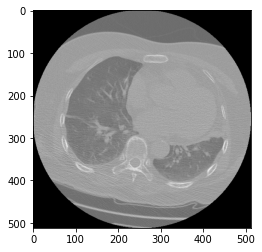

In [10]:
plt.imshow(ct_norm[57], cmap="gray")

In [11]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # CLAHE(Contrast Limited Adaptive Histogram Equalization) filter for enhancing the contrast of an image
ct_norm_improved = []
for layer in ct_norm:
    ct_norm_improved.append(clahe.apply(layer.astype(np.uint8)))  # Applying CLAHE filter to the image

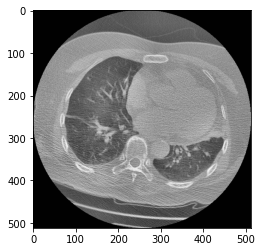

In [23]:
plt.imshow(ct_norm_improved[57], cmap="gray")

In [12]:
centeral_area = ct_norm_improved[len(ct_norm_improved)//2][100:400, 100:400]
kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
centroids = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centroids)
print(threshold)

127.49312861370557


In [13]:
lung_masks = []
for layer in ct_norm_improved:
    ret, lung_roi = cv2.threshold(layer, threshold, 255, cv2.THRESH_BINARY_INV)
    lung_roi = cv2.erode(lung_roi, kernel=np.ones([4,4]))
    lung_roi = cv2.dilate(lung_roi, kernel=np.ones([13,13]))
    lung_roi = cv2.erode(lung_roi, kernel=np.ones([8,8]))

    labels = measure.label(lung_roi)        # Labelling different regions in the image
    regions = measure.regionprops(labels)   # Extracting the properties of the regions
    good_labels = []
    for prop in regions:        # Filtering the regions that are not too close to the edges
        B = prop.bbox           # Regions that are too close to the edges are outside regions of lungs
        if B[2]-B[0] < 475 and B[3]-B[1] < 475 and B[0] > 40 and B[2] < 472:
            good_labels.append(prop.label)
    lung_roi_mask = np.zeros_like(labels)
    for N in good_labels:
        lung_roi_mask = lung_roi_mask + np.where(labels == N, 1, 0)

    # Steps to get proper segmentation of the lungs without noise and holes
    contours, hirearchy = cv2.findContours(lung_roi_mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    external_contours = np.zeros(lung_roi_mask.shape)
    for i in range(len(contours)):
        if hirearchy[0][i][3] == -1:  #External Contours
            area = cv2.contourArea(contours[i])
            if area>518.0:
                cv2.drawContours(external_contours,contours,i,(1,1,1),-1)
    external_contours = cv2.dilate(external_contours, kernel=np.ones([4,4]))

    external_contours = cv2.bitwise_not(external_contours.astype(np.uint8))
    external_contours = cv2.erode(external_contours, kernel=np.ones((7,7)))
    external_contours = cv2.bitwise_not(external_contours)
    external_contours = cv2.dilate(external_contours, kernel=np.ones((12,12)))
    external_contours = cv2.erode(external_contours, kernel=np.ones((12,12)))

    external_contours = external_contours.astype(np.uint8)      # Final segmentated lungs mask
    lung_masks.append(external_contours)


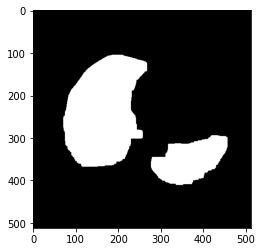

In [14]:
plt.imshow(lung_masks[57], cmap="gray")

In [15]:
extracted_lungs = []
for lung, mask in zip(ct_norm_improved,lung_masks):
    extracted_lungs.append(cv2.bitwise_and(lung, lung, mask=mask))

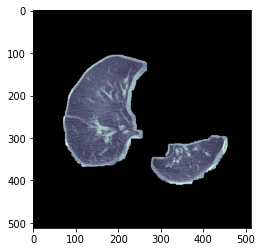

In [16]:
plt.imshow(extracted_lungs[57], cmap="bone")

In [17]:
X = np.array(extracted_lungs)
X.shape

(161, 512, 512)

In [18]:
X = (X-127.0)/127.0
X = X.astype(np.float32)
X.dtype

dtype('float32')

In [19]:
print("Min:",X.min(),"\nMax:",X.max())

Min: -1.0 
Max: 1.007874


In [20]:
X = np.reshape(X, (len(X), 512, 512, 1))
X.shape

(161, 512, 512, 1)

In [21]:
predictions = model.predict(X)
predictions.shape

2023-05-08 10:54:03.908885: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.3.2 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-05-08 10:54:03.909966: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops_fused_impl.h:625 : UNIMPLEMENTED: DNN library is not found.
2023-05-08 10:54:03.910015: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): UNIMPLEMENTED: DNN library is not found.
	 [[{{node model_2/conv2d_38/Relu}}]]


UnimplementedError: Graph execution error:

Detected at node 'model_2/conv2d_38/Relu' defined at (most recent call last):
    File "/usr/local/python/3.9-2022.05/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/local/python/3.9-2022.05/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/local/python/3.9-2022.05/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/usr/local/python/3.9-2022.05/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/usr/local/python/3.9-2022.05/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/slurmtmp.24926085/ipykernel_8455/4063228158.py", line 1, in <cell line: 1>
      predictions = model.predict(X)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/users/PGS0302/skumawat/.local/lib/python3.9/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'model_2/conv2d_38/Relu'
DNN library is not found.
	 [[{{node model_2/conv2d_38/Relu}}]] [Op:__inference_predict_function_1082]

In [45]:
print("Dtype:",predictions.dtype,"\nMin:",predictions.min(),"\nMax:",predictions.max())

Dtype: uint8 
Min: 0 
Max: 255


In [46]:
predictions[predictions>=0.5] = 255
predictions[predictions<0.5] = 0
predictions = predictions.astype(np.uint8)

In [47]:
pred = list(predictions)
pred = [np.squeeze(i) for i in pred]
len(pred)


161

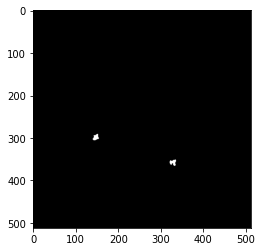

In [48]:
plt.imshow(pred[51], cmap="gray")

In [49]:
def display(imgs,mask):
    j = 1
    for im,mk in zip(imgs,mask):
        plt.figure(figsize=(20,300))
        plt.subplot(50,3,j)
        plt.imshow(np.squeeze(im), cmap="gray")
        plt.subplot(50,3,j+1)
        plt.imshow(np.squeeze(mk), cmap="gray")
        plt.subplot(50,3,j+2)
        plt.imshow(cv2.addWeighted(np.squeeze(im), .5, np.squeeze(mk), .5, 0), cmap="gray")
        j += 3

In [50]:
def display2(imgs, titles=None, cmap="bone"):
    n = len(list(imgs))
    r = n//3 if n%3==0 else (n//3)+1
    plt.figure(figsize=(25,int(8*r)))
    for i,img in enumerate(imgs):
        plt.subplot(r,3,i+1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img, cmap=cmap)

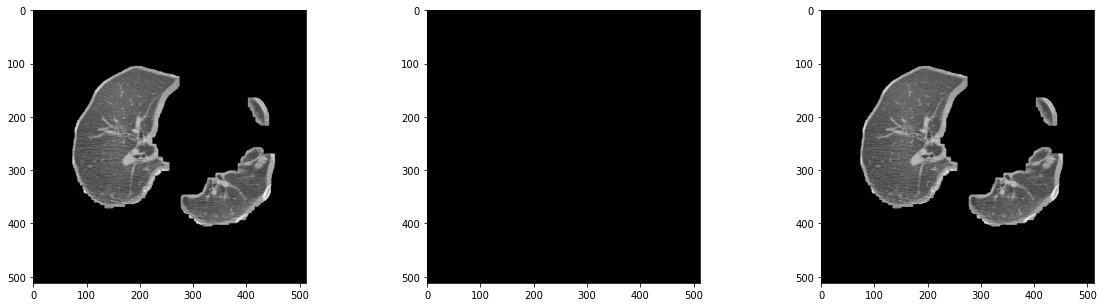

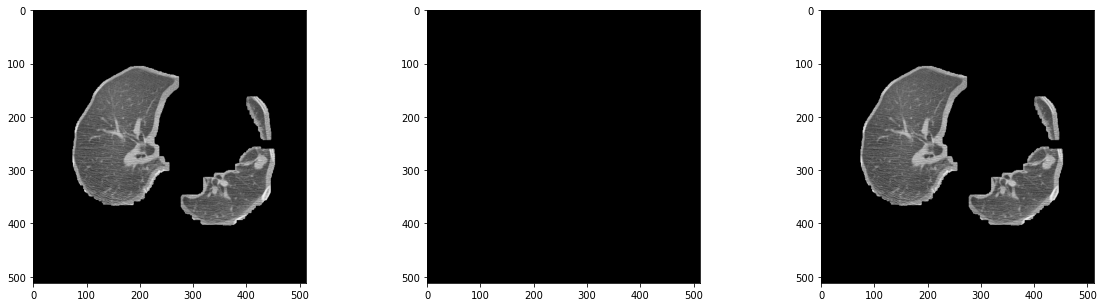

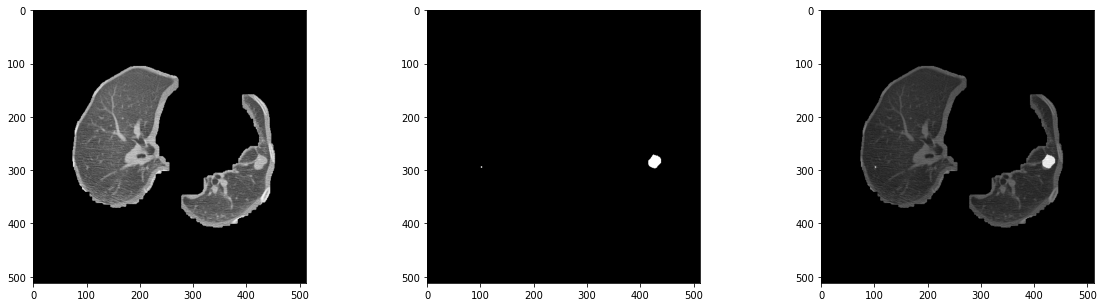

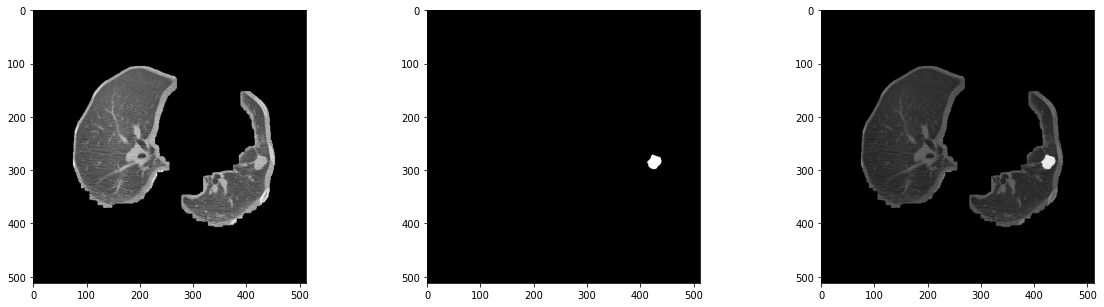

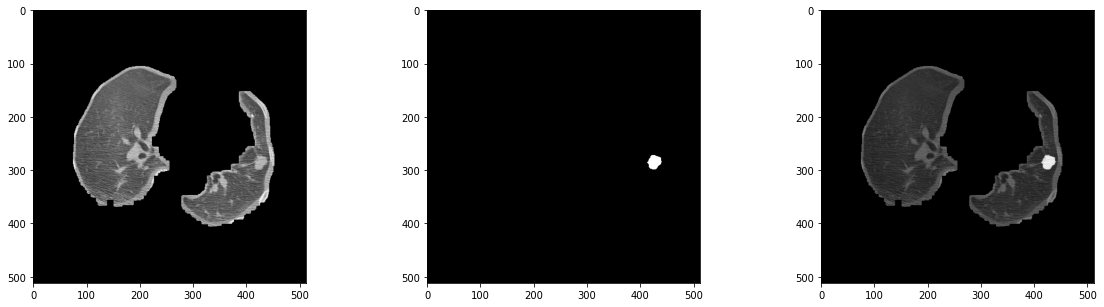

In [51]:
display(extracted_lungs[65:70],pred[65:70])

In [52]:
bboxes = []
centroids = []
diams = []
for mask in pred:
    mask = cv2.dilate(mask, kernel=np.ones((5,5)))
    labels = measure.label(mask)
    regions = measure.regionprops(labels)
    bb = []
    cc = []
    dd = []
    for prop in regions:
        B = prop.bbox
        C = prop.centroid
        D = prop.equivalent_diameter_area
        bb.append((( max(0, B[1]-8), max(0, B[0]-8) ),( min(B[3]+8, 512), min(B[2]+8, 512) )))    # ((x1,y1),(x2,y2))
        cc.append(C)    # (y,x)
        dd.append(D)
    bboxes.append(bb)
    centroids.append(cc)
    diams.append(dd)

In [55]:
bboxes[65:71]

[[],
 [((405, 261), (449, 307)), ((91, 283), (114, 306))],
 [((403, 261), (450, 309))],
 [((403, 262), (450, 309))],
 [((400, 187), (424, 210)), ((403, 263), (449, 309))],
 [((401, 187), (423, 209)), ((407, 263), (449, 308))]]

In [61]:
centroids[65:71]


[[],
 [(283.75, 426.4439393939394), (294.0, 101.87234042553192)],
 [(284.62670299727523, 426.01089918256133)],
 [(284.7877169559413, 426.01068090787714)],
 [(197.84313725490196, 411.54901960784315), (285.0, 425.8264462809917)],
 [(197.57142857142858, 411.42857142857144),
  (284.2405271828666, 427.05766062602964)]]

In [62]:
bs = []
mimgs = copy.deepcopy(extracted_lungs)
for i,(img,boxes) in enumerate(zip(mimgs,bboxes)):
    for rect in boxes:
        img = cv2.rectangle(img, rect[0], rect[1], (255), 2)

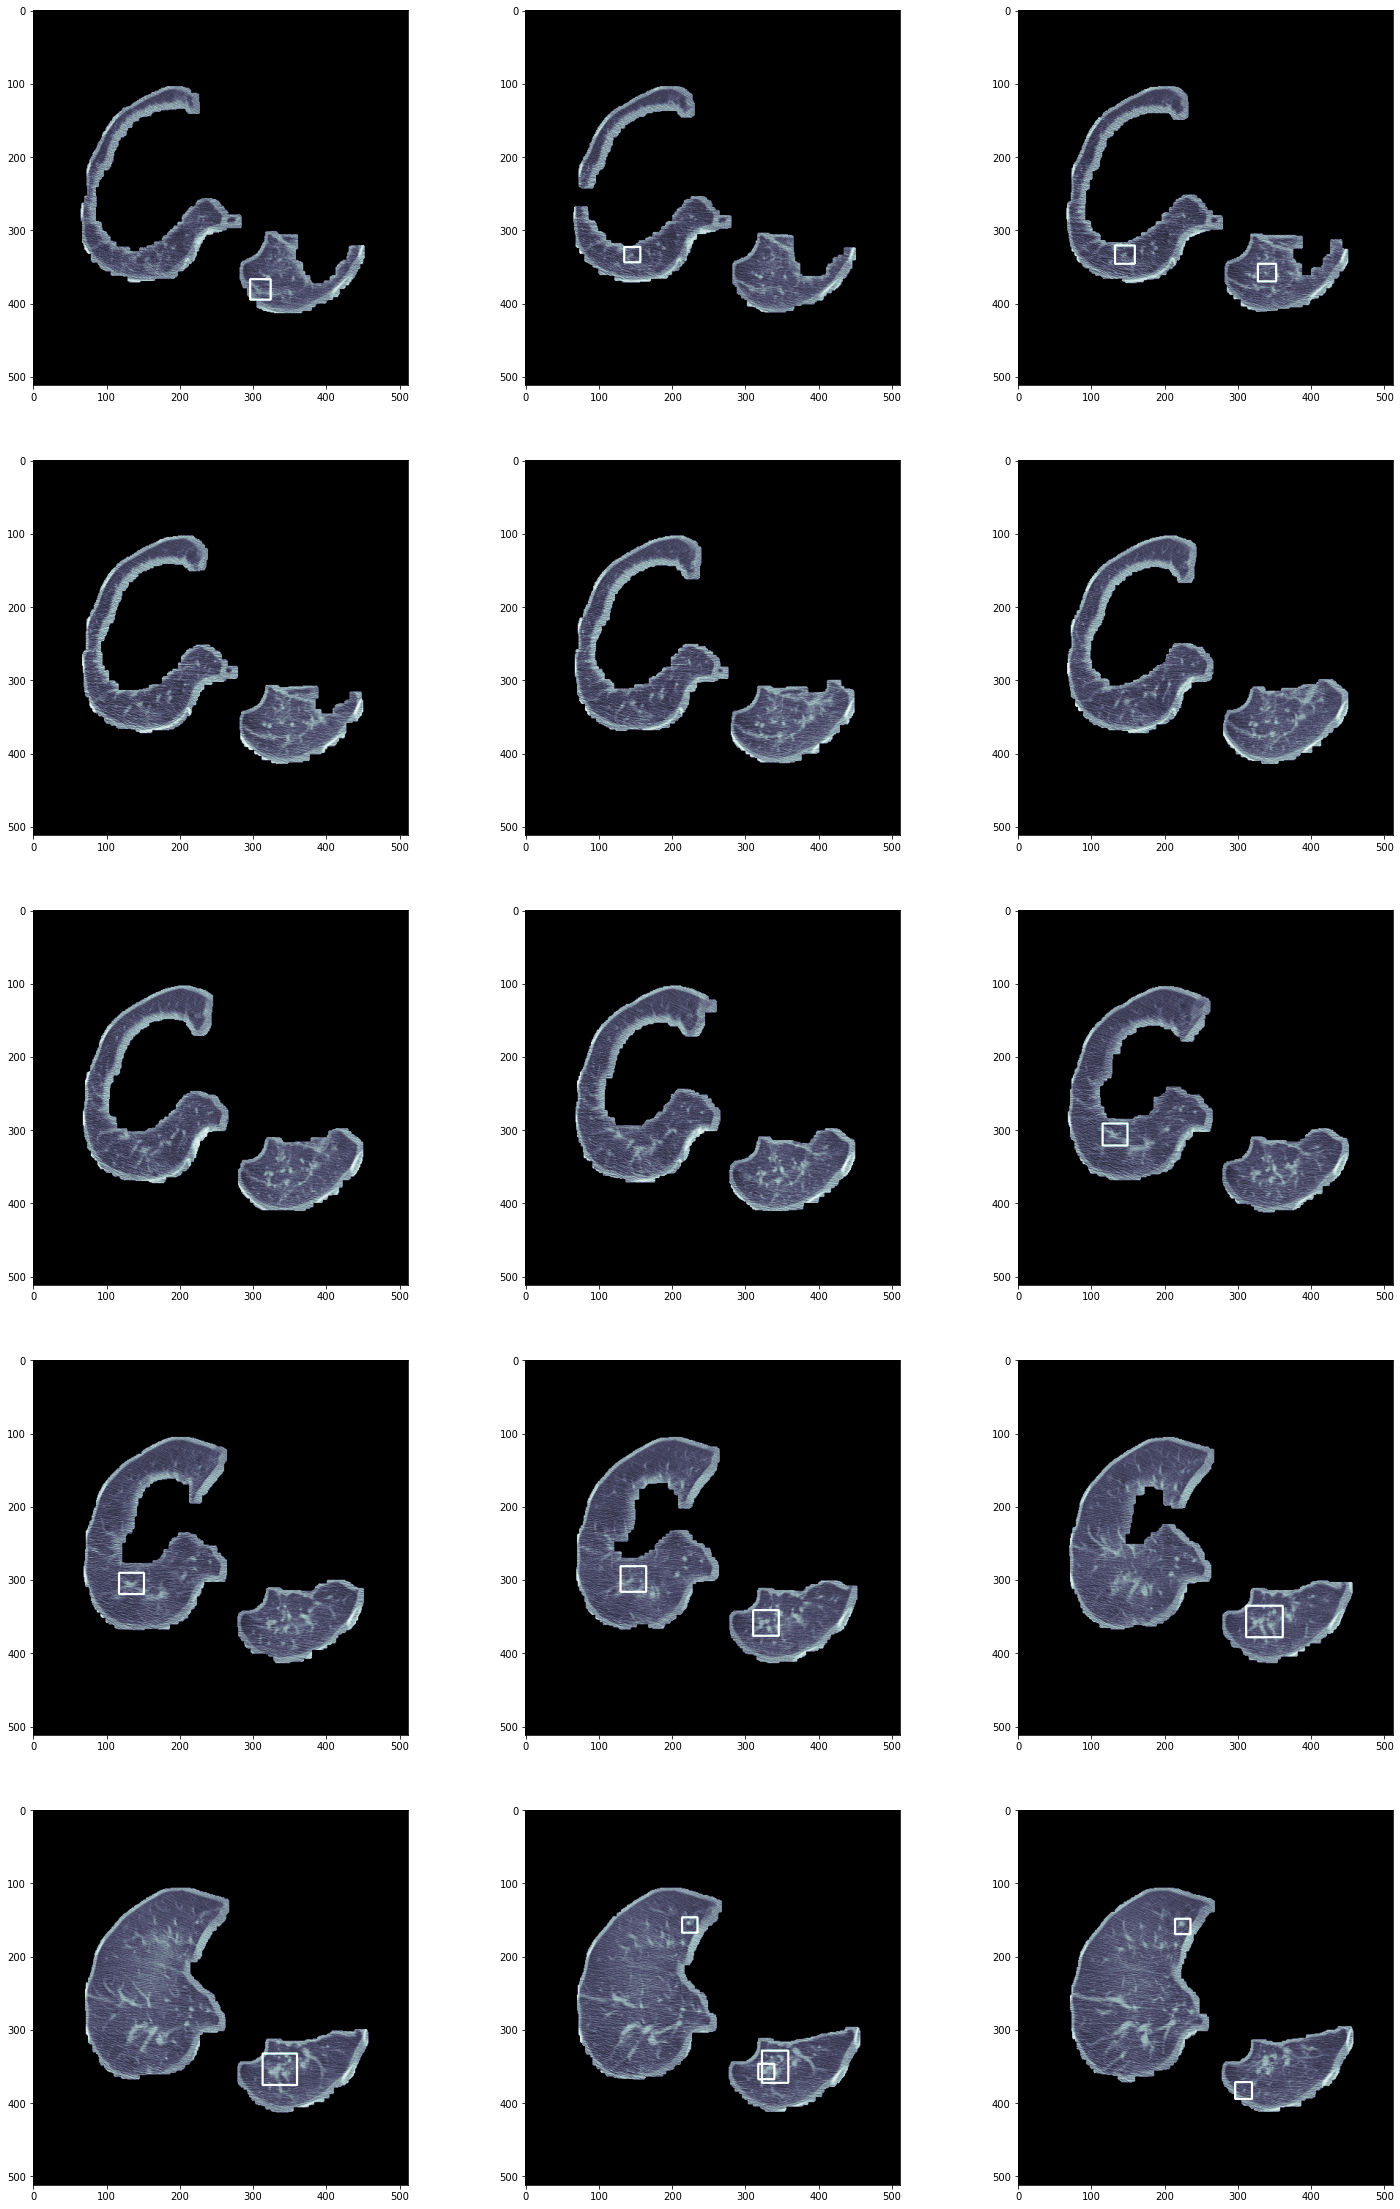

In [63]:
display2(mimgs[40:55])

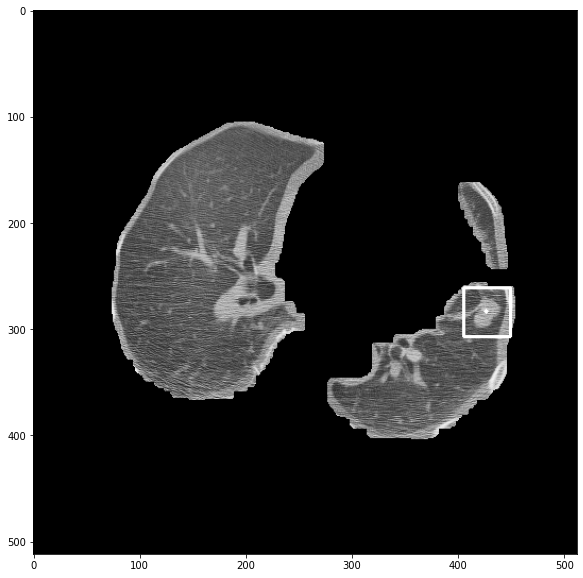

In [64]:
idx = 66
v = copy.deepcopy(extracted_lungs)
plt.figure(figsize=(10,10))
i = cv2.rectangle(v[idx], bboxes[idx][0][0], bboxes[idx][0][1], (255), 2)
i = cv2.circle(i, (int(centroids[idx][0][1]), int(centroids[idx][0][0])), 2, (255), -1)
plt.imshow(i, cmap='gray')

In [68]:
diams[65:71]

[[],
 [28.988585676524604, 7.735777827895049],
 [30.570538527078803],
 [30.881327999401787],
 [8.058239062071396, 30.403485153477522],
 [6.6755811781245455, 27.80029502818709]]

In [69]:
diams[66][0]*space[0]

15.90974766754015

In [70]:
ls

annotations.csv    evaluationScript/        subset0/       Untitled.ipynb
candidates.csv     FPR_classifier_model.h5  Subset0_0/
candidates_V2.csv  sampleSubmission.csv     UNet_model.h5


In [71]:
fpr_model = tf.keras.models.load_model("FPR_classifier_model.h5")

In [72]:
originals = copy.deepcopy(ct_norm_improved)
final_boxes = []
for i,(img,bbox) in enumerate(zip(originals, bboxes)):
    img_boxes = []
    for box in bbox:
        x1 = box[0][0]
        y1 = box[0][1]
        x2 = box[1][0]
        y2 = box[1][1]
        if abs(x1-x2) <=50 or abs(y1-y2)<=50:
            x = (x1+x2)//2
            y = (y1+y2)//2
            x1 = max(x-25, 0)
            x2 = min(x+25, 512)
            y1 = max(y-25, 0)
            y2 = min(y+25, 512)
            imgbox = img[y1:y2,x1:x2]
            img_boxes.append(imgbox)
        else:
            imgbox = img[y1:y2,x1:x2]
            img_boxes.append(imgbox)
    final_boxes.append(img_boxes)

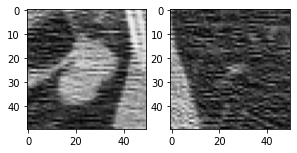

In [73]:
plt.figure(figsize=(15,15))
for i,img in enumerate(final_boxes[66]):
    plt.subplot(1,6,i+1)
    plt.imshow(img, cmap="gray")

In [74]:
fpr_preds = []
for i in final_boxes:
    each_p = []
    for img in i:
        if img.shape != (50,50):
            img = np.resize(img, (50,50))
        img = img/255.
        img = np.reshape(img, (1,50,50,1))
        pred = fpr_model.predict(img)
        pred = int(pred>=0.5)
        each_p.append(pred)
    fpr_preds.append(each_p)

1/1 [==============================] - 0s 28ms/step


In [75]:
bboxes[66]

[((405, 261), (449, 307)), ((91, 283), (114, 306))]

In [76]:
for i in range(len(diams)):
    if len(diams[i]):
        for j in range(len(diams[i])):
            diams[i][j] = diams[i][j]*space[0] 

In [77]:
final_img_bbox = []
cancer = []
df = pd.DataFrame(columns = ['Layer', 'Position (x,y)', 'Diameter (mm)', 'BBox [(x1,y1),(x2,y2)]'])
e_lungs = copy.deepcopy(ct_norm_improved)
for i,(img,bbox,preds,cents,dms) in enumerate(zip(e_lungs, bboxes, fpr_preds, centroids, diams)):
    token = False
    for box,pred,cent,dm in zip(bbox,preds,cents,dms):
        if pred:
            x1 = box[0][0]
            y1 = box[0][1]
            x2 = box[1][0]
            y2 = box[1][1]
            img = cv2.rectangle(img, (x1,y1), (x2,y2), (255), 2)
            dct = pd.DataFrame({'Layer':i, 'Position (x,y)':[f"{cent[::-1]}"], 'Diameter (mm)':dm, 'BBox [(x1,y1),(x2,y2)]':[f"{list(box)}"]})
            df = pd.concat([df,dct], ignore_index = True)
            token = True
    final_img_bbox.append(img)
    cancer.append(token)

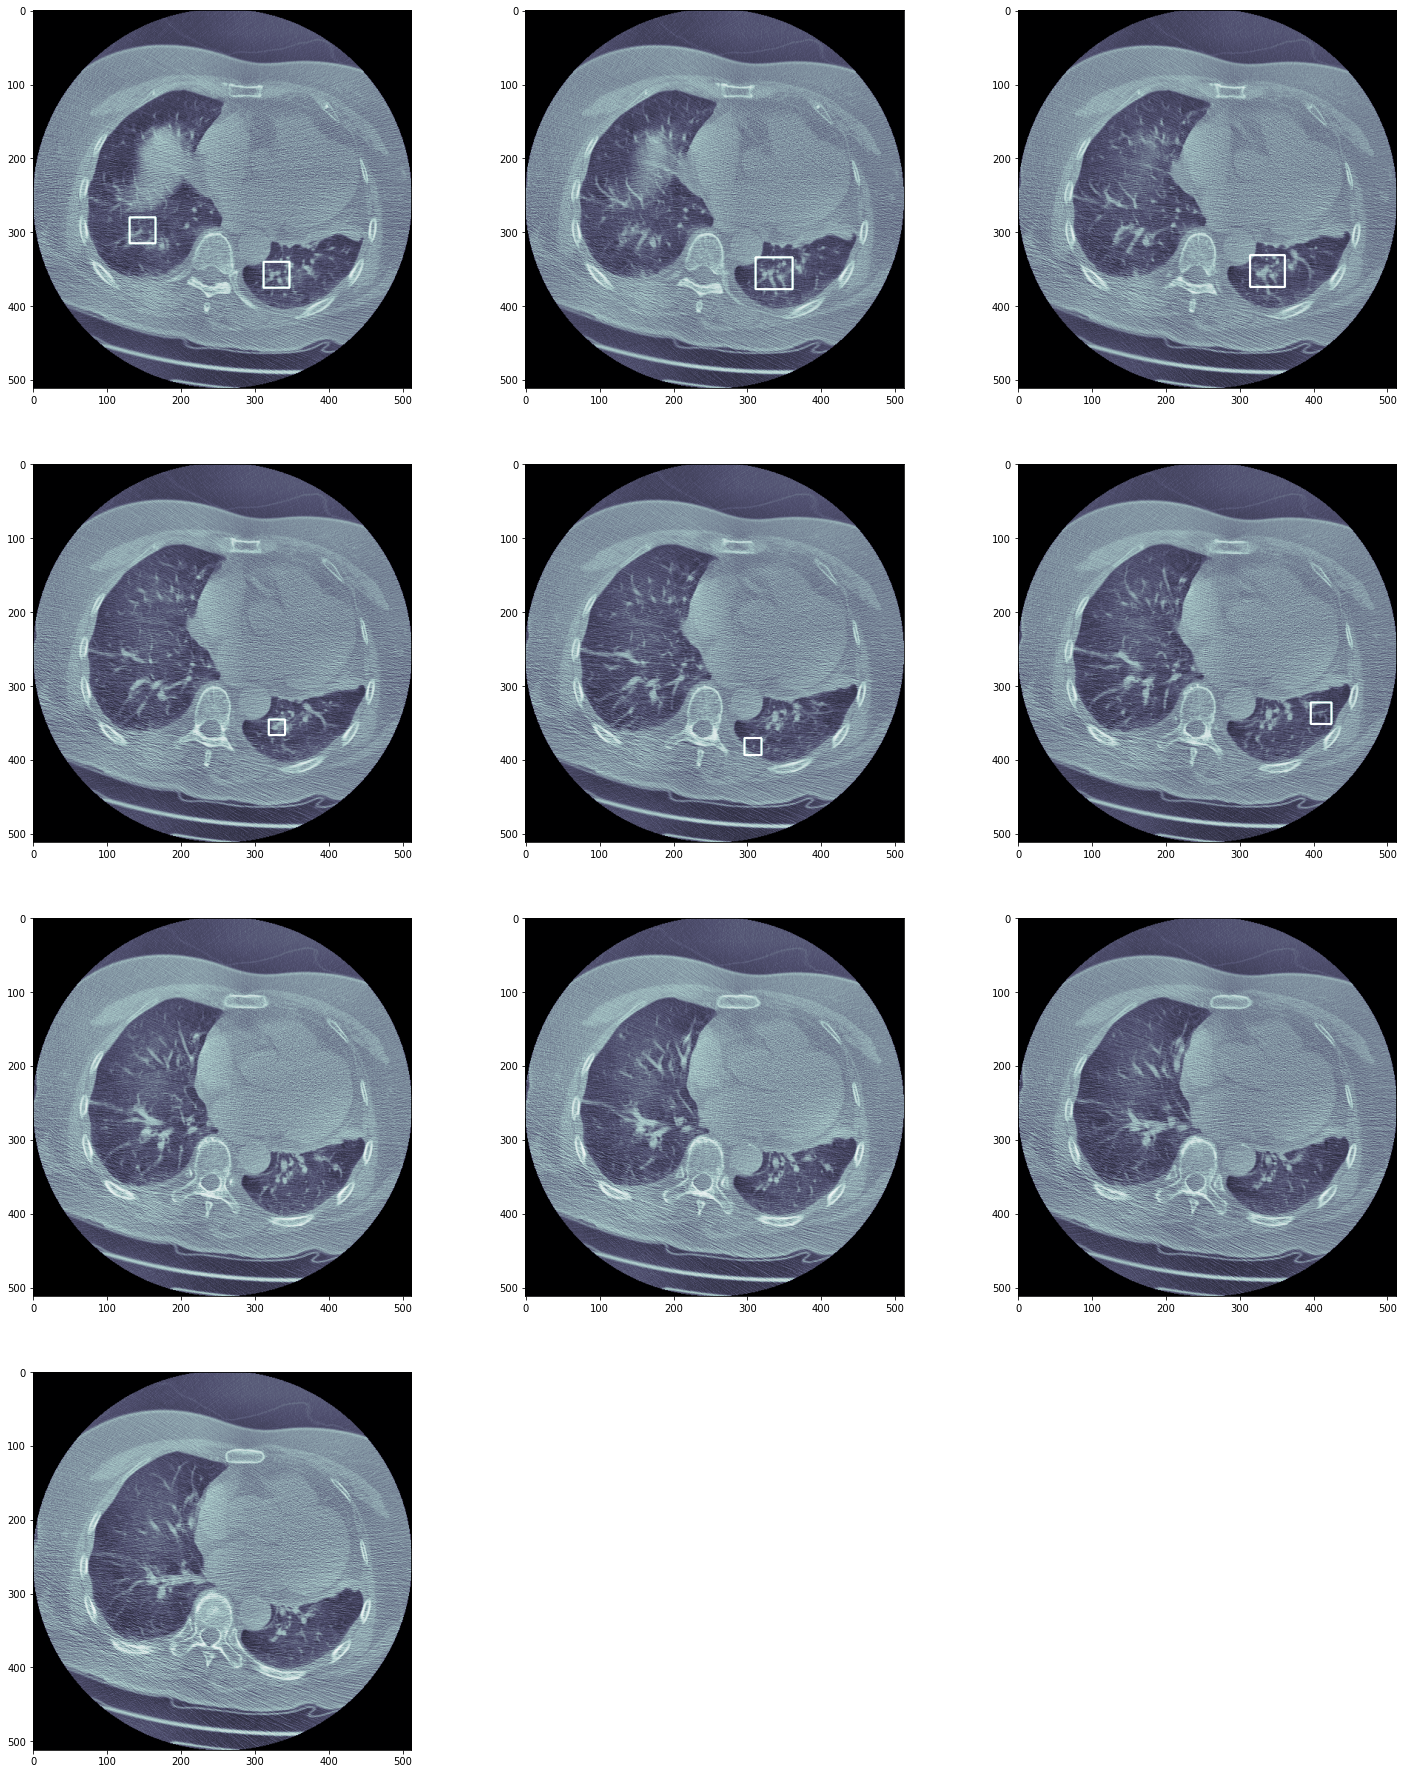

In [79]:
display2(final_img_bbox[50:60])

In [80]:
cancer[50:60]

[True, True, True, True, True, True, False, False, False, False]

In [81]:
df = df.reset_index(drop=True)
df.head()

Layer                           Position (x,y) Diameter (mm)  \
0    32   (340.9347826086956, 402.0652173913044)      4.200203   
1    33               (340.8723404255319, 402.0)      4.245612   
2    39           (156.80357142857142, 350.4375)      6.553908   
3    39   (307.3252032520325, 382.5772357723577)      6.868215   
4    40  (309.45112781954884, 380.3157894736842)      7.141956   

     BBox [(x1,y1),(x2,y2)]  
0  [(330, 391), (353, 414)]  
1  [(330, 391), (353, 414)]  
2  [(143, 337), (171, 365)]  
3  [(294, 369), (322, 397)]  
4  [(296, 367), (324, 395)]